In [254]:
import numpy as np

## GIVENS METHOD

In [743]:
def givens(a,b):
    '''
    For a vectors [a,b] return cos and sin value needed for givens rotation matrix
    '''
    if b == 0.0:
        c = 1.0
        s = 0.0
    else:
        if abs(b) > abs(a):
            tau = -a/b
            s = 1.0/(1.0 + tau**2)**0.5
            c = s*tau
        else:
            tau = -b/a
            c = 1.0/(1.0 + tau**2)**0.5
            s = c*tau
    return [c,s]

In [798]:
def upperTriagSolve(A,b):
    '''
    Solve an upper triangular system Ux = b
    '''
    U = A.copy()
    sol = b.copy()
    n = A.shape[0] #A is nxn
    for i in range(n-1,-1,-1):
        sol[i] = (sol[i] - np.matmul(U[i,i+1:n-1],sol[i+1:n-1]))/U[i,i]
    return sol

In [799]:
def lsgivens(A,b):
    '''
    For a Matrix A and vector b, return the least square solution to Ax = b
    '''
    temp = A.copy() # so we don't overwrite A itself
    m,n = temp.shape
    
    mat = np.c_[temp,b] #augmented matrix with b as the last column

    for j in range(n):
        for i in range(m-1,j,-1):
            c,s = givens(mat[i-1,j],mat[i,j])
            rotMat = np.matrix([[c,-s],[s,c]])
            mat[i-1:i+1,j:n+1] = np.matmul(rotMat,mat[i-1:i+1,j:n+1])
#   # Get R: the upper traingular mat
    R = mat[0:n,0:n]
    c = mat[0:n,n]
    d = mat[n:m,n]
    
#   #Solve for x_ls
    # The upperTriagSolve I wrote seems to have some problem, so using the built in function
    xls = np.linalg.solve(R,c) 
    # xls = upperTriagSolve(R,c)
    
#   return xls
    return xls

Define a test mm x nn matrix A, and vector b

In [800]:
mm = 10
nn = 3
A = 10*np.random.rand(mm,nn)
b = np.random.rand(mm,1)

round_to_decimal = 1 #to get cleaner results

Get the least square solution for (A,b):

In [801]:
lsgivens(A,b)

array([ 0.01785741, -0.00216921,  0.08132083])

For comparison, here is the actual solution from numpy's built-in least square solver

In [802]:
np.linalg.lstsq(A,b)[0]

array([[ 0.01785741],
       [-0.00216921],
       [ 0.08132083]])

Check the error against numpy's built in least square solver

In [803]:
np.linalg.norm(lsgivens(A,b) - np.linalg.lstsq(A,b)[0],2)

0.10676730660778001

Our solution from givens matches that from Numpy's native least square solver.

# Modified Gram Schmidt

In [804]:
def lsmgs(A,b):
    '''
    For a matrix A and vector b, return the least square solution to Ax = b
    '''
    temp = A.copy()
    m,n = temp.shape
    
    r = np.zeros((n,n))
    q = np.zeros((m,n))
    
    for k in range(0,n):
        r[k,k] = np.linalg.norm(temp[0:m,k],ord = 2)
        q[0:m,k] = temp[0:m,k]/r[k,k]
        
        for j in range(k+1,n):
            r[k,j] = np.matmul(np.transpose(q[0:m,k]),A[0:m,j])
            temp[0:m,j] = temp[0:m,j] - q[0:m,k]*r[k,j]
    
    # Solve r = Q^T b
#     xls = upperTriagSolve(r,np.matmul(np.transpose(q),b))
    xls = np.linalg.solve(r,np.matmul(np.transpose(q),b))
    
    return xls

Get the least square solution for our test (A,b):

In [805]:
lsmgs(A,b)

array([[ 0.01785741],
       [-0.00216921],
       [ 0.08132083]])

For comparison, here is the actual solution from numpy's built-in least square solver

In [806]:
np.linalg.lstsq(A,b)[0]

array([[ 0.01785741],
       [-0.00216921],
       [ 0.08132083]])

Our solution from givens matches that from Numpy's native least square solver.

Check the error against numpy's in built least square solver

In [807]:
np.linalg.norm(lsmgs(A,b) - np.linalg.lstsq(A,b)[0],2)

9.9202069665849502e-17

## Test with known solution

We want to create a problem Ax = b such that the difference in solution between the Givens and MGS solution is maximized. We know that the MGS solution is more sensitive to the condition of the matrix A and the level of orthogonalization decreases when A is close to being rank-deficient. The worst case scenario for MGS would be for a singular matrix. However, in this question want A to be full rank. 

So we will construct our matrix A as a rank one matrix. First, we create an arbitrary column $col$ with random entries:

In [808]:
# mm = 10
nn = 9
col = np.random.rand(mm,1)

Now, we create a vector x which is simply the list of numbers from 1 to nn.

In [809]:
x = np.array(range(1,nn+1)).reshape(nn,1)
x.reshape(9,)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Normalize it so $||x||_2 = 1$

In [810]:
x = x/(1.0*max(x)[0])
x

array([[ 0.11111111],
       [ 0.22222222],
       [ 0.33333333],
       [ 0.44444444],
       [ 0.55555556],
       [ 0.66666667],
       [ 0.77777778],
       [ 0.88888889],
       [ 1.        ]])

Now, we create a rank 1 matrix by traking $col~x^T$. This is a singular matrix.

In [811]:
testA = np.matmul(col,np.transpose(x))
print "The rank of testA: {}".format(np.linalg.matrix_rank(testA))

The rank of testA: 1


Now, we add some noise to this matrix to make it full rank

In [812]:
noise_level = 0.1
noise = noise_level*np.random.rand(mm,nn)
testA = testA + noise

In [813]:
print "The rank of testA: {}".format(np.linalg.matrix_rank(testA))

The rank of testA: 9


Now, we construct $b$ to be the exact product $Ax$:

In [814]:
b = np.matmul(testA,x)

With this setup, we know that the solution to the least square problem must be the x we created.

Check the Givens solution:

In [815]:
x_givens = lsgivens(testA,b)
print "x_givens =\n {}".format(x_givens.reshape(nn,1))
print "\nThe error in givens e_1 = {}".format(np.linalg.norm(x_givens.reshape(nn,1) - x, 2))

x_givens =
 [[ 0.11111111]
 [ 0.22222222]
 [ 0.33333333]
 [ 0.44444444]
 [ 0.55555556]
 [ 0.66666667]
 [ 0.77777778]
 [ 0.88888889]
 [ 1.        ]]

The error in givens e_1 = 1.76367464912e-14


In [816]:
x_mgs = lsmgs(testA,b)
print "x_givens =\n {}".format(x_mgs)
print "\nThe error in givens e_1 = {}".format(np.linalg.norm(x_mgs - x, 2))

x_givens =
 [[ 0.11111111]
 [ 0.22222222]
 [ 0.33333333]
 [ 0.44444444]
 [ 0.55555556]
 [ 0.66666667]
 [ 0.77777778]
 [ 0.88888889]
 [ 1.        ]]

The error in givens e_1 = 8.46605765668e-13


# Diverging Solutions

The solutions from these two methods would be the most divergent when A is as close to singular as possible. Below, we change the level of noise added to our original singular A and see how the errors for the solutions change. We expect that for the lowest noise (when A is very close to being singular), the difference in errors would be the highest.

In [817]:
noise_range = [noise/1000.0 for noise in range(1,1000,10)]

In [818]:
x = np.array(range(1,nn+1)).reshape(nn,1)
x = np.divide(x,1.0*max(x)[0])

In [819]:
noise = np.random.rand(mm,nn)

In [820]:
e_givens_list = list()
e_mgs_list = list()

for noise_level in noise_range:
    
    # Add noise
    noisyA = testA + noise_level*noise
    b = np.matmul(noisyA,x)
    
    #Get givens solution
    x_givens = lsgivens(noisyA,b).reshape(nn,1)
    e_givens_list.append(np.linalg.norm(x_givens - x, 2))
    
#     #Get mgs solution
    x_mgs = lsmgs(noisyA,b)
    e_mgs_list.append(np.linalg.norm(x_mgs - x, 2))
    

In [821]:
import matplotlib.pyplot as plt
%matplotlib inline  
import math

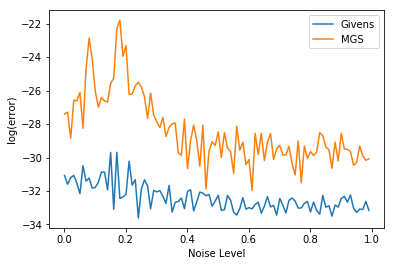

In [822]:
plt.plot(noise_range,[math.log(x) for x in e_givens_list],label = 'Givens')
plt.plot(noise_range,[math.log(x) for x in e_mgs_list],label = 'MGS')
plt.xlabel('Noise Level')
plt.ylabel('log(error)')
plt.legend()
plt.show()

This (somewhat) proves our hypothesis. The difference in errors is much larger for lower levels of noise (i.e. A being closer to being rank deficient). In this regime, Givens seems to always provide lower error than MGS. This is in contrast to the earlier result on a completely random matrix A where the MGS method seemed to provide lower error.